In [45]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gti-upm/leapgestrecog
! unzip leapgestrecog.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
leapgestrecog.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  leapgestrecog.zip
replace leapGestRecog/00/01_palm/frame_00_01_0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
# Instead of importing from keras directly, import from tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [47]:
path = "./leapGestRecog"
folders = os.listdir(path)
inner_folders = os.listdir(path+"/01")
categories=[]
for i in inner_folders:
  category = i.split('_', maxsplit=1)[1:]
  categories.append(category[0])
num_classes = len(categories)
categories

['palm',
 'index',
 'fist',
 'down',
 'palm_moved',
 'c',
 'ok',
 'thumb',
 'l',
 'fist_moved']

In [48]:
df = pd.DataFrame(columns=['filepaths','categories'])
paths , category = [], []
for folder in folders:
  inner_folders = os.listdir(path+'/'+folder)
  for inner_f in inner_folders:
    files = os.listdir(path+'/'+folder+"/"+inner_f)
    for file in files:
      paths.append(folder+'/'+inner_f+'/'+file)
      category.append(inner_f.split('_', maxsplit=1)[1])
df['filepaths'] = paths
df['categories'] = category


In [49]:
im_size = (224, 224)
im_width, im_height = im_size
im_channels=1
batch_size = 50

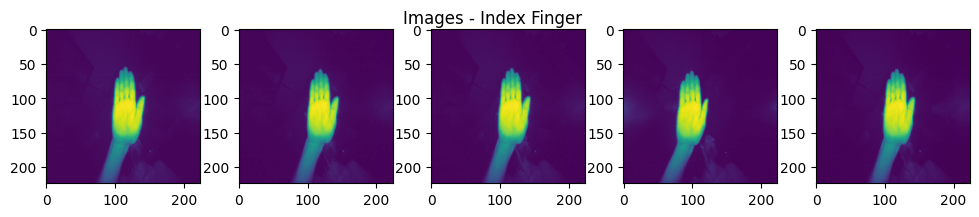

In [50]:

fig = plt.figure(figsize=(12,2))
fig.suptitle("Images - Index Finger")

for i in range(5):
  img = Image.open(path+'/'+df['filepaths'][i])
  img = img.resize(im_size)
  plt.subplot(1, 5, i+1)
  plt.imshow(img)
  # print(img.shape)
plt.show()


In [51]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=123)
train_df[:5]

,filepaths,categories
9642,09/02_l/frame_09_02_0199.png,l
17924,01/04_fist_moved/frame_01_04_0063.png,fist_moved
1642,03/02_l/frame_03_02_0035.png,l
9670,09/02_l/frame_09_02_0180.png,l
16860,01/08_palm_moved/frame_01_08_0200.png,palm_moved


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Corrected typo from 1/.255 to 1./255
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [53]:
val_datagen = ImageDataGenerator(rescale=1/.255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 2000 validated image filenames belonging to 10 classes.


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define your model
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(im_size[0], im_size[1], 1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')  # Adjust output layer for your number of classes
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the callbacks
earlystop = EarlyStopping(patience=10, restore_best_weights=True)  # Optional: restore the best weights
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',  # Use 'val_accuracy' for TensorFlow 2.x (instead of 'val_acc')
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

# Combine callbacks
callbacks = [earlystop, learning_rate_reduction]


In [56]:
# Assuming you have train_df, path, im_size, batch_size, categories defined similar to val_df etc.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Your existing train_datagen code
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Corrected typo from 1/.255 to 1./255
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create train_generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,  # Replace with your training dataframe
    path+'/',  # Assuming path is defined elsewhere
    x_col='filepaths',  # Replace with the column name for image file paths
    y_col='categories',  # Replace with the column name for labels
    target_size=im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

# ... rest of your code (model definition, callbacks, model.fit) ...

Found 16000 validated image filenames belonging to 10 classes.


In [ ]:
# Assuming you have imported necessary libraries and defined your model as 'model'

# Compile the model before fitting
model.compile(optimizer='adam',  # You can choose other optimizers like 'sgd', 'rmsprop', etc.
              loss='categorical_crossentropy',  # Use 'binary_crossentropy' for binary classification
              metrics=['accuracy'])  # You can add other metrics like 'precision', 'recall', etc.

# Now you can fit the model
model_hist = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=100,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 54/100 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.1350 - loss: 2.2968

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(model_hist.history['accuracy'], label='Training')
plt.plot(model_hist.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_hist.history['loss'], label='Training')
plt.plot(model_hist.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.savefig("Training History.jpg")
plt.show()


In [ ]:
model.save('hand_gesture_recognition.h5')

In [ ]:
basic_test_generator = train_datagen.flow_from_dataframe(
    test_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

In [ ]:
loss, acc = model.evaluate(basic_test_generator)
print("Testing Loss:", loss)
print("Testing Accuracy:", acc)

In [ ]:
from PIL import Image

In [ ]:
test_df[40:48]


In [ ]:
sample_imgs=[]
for img_paths in test_df[100:108]['filepaths']:
  img = Image.open(path+'/'+img_paths)
  img = img.resize(im_size)
  img = img.convert('L')
  img = np.array(img)
  img = img.reshape((img.shape[0], img.shape[1], 1))
  sample_imgs.append(img)
sample_imgs = np.array(sample_imgs)
sample_imgs.shape

In [ ]:
preds = model.predict(sample_imgs)
preds = np.argmax(preds, axis=1)

In [ ]:
preds

In [ ]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Model Inference")
ind=1
for img in sample_imgs:
  plt.subplot(2,4,ind)
  plt.imshow(img)
  plt.title(categories[preds[ind-1]])
  ind+=1
plt.savefig("Hand Gesture model Inference.jpg")
plt.show()